## 국민연금 가입자 조회

In [ ]:
%pip install seaborn

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

pd.set_option('display.float_format',  '{:.1f}'.format)
pd.set_option('display.max_columns', None)

plt.rcParams['font.family'] = "NanumGothic"

DATA_DIR = '.'


### 데이터 (국민연금공단_국민연금 가입 사업장 내역)

- 데이터셋 출처: 공공 데이터 포털(data.go.kr) **2024년 5월 21일 기준** 데이터
- 형태: 파일데이터 (csv)

사업장 컬럼별 상세설명

- 자료생성년월 → 자격마감일(사유발생일이 속하는 달의 다음달 15일)까지 신고분 반영
- 당월고지금액 → 국민연금법 시행령 제5조에 의거 기준소득월액 상한액 적용으로 실제소득과 고지금액은 상이할 수 있음

  - ■ 상한액 2019.7.~2020.6. 4,860,000원(2019.7.1.기준)
  - ■ 상한액 2020.7.~2021.6. 5,030,000원(2020.7.1.기준)
  - ■ 상한액 2021.7.~2022.6. 5,240,000원(2021.7.1.기준)

- 신규취득자수 → 납부재개 포함 : ※ 전달 고지대상자와 비교하므로 실제 취득자와 상이할 수 있음 (초일취득 (고지)초일이 아닌경우 (당월 미고지되며 다음달 취득자수에 반영)
- 상실가입자수 → 납부예외 포함 : ※ 전달 고지대상자와 비교하므로 실제 퇴사자와 상이할 수 있음 (초일이 아닌 상실자는 다음달 상실자수에 반영)

※ 국민연금법 제6조, 8조, 동법 시행령 제18조에 의거 60세 도달하거나 퇴직연금수급자, 조기노령연금 수급권을 취득한 자는 가입대상에서 제외되며, 18세미만, 기초수급자는 본인희망에 의해 제외될 수 있음

In [ ]:
# url="https://drive.google.com/file/d/1jFlvEeacVh32VFMz0Ca9lOicAem1QfsP/view?usp=sharing"
# path='https://drive.google.com/uc?id='+url.split('/')[-2]
# print("▶ 공유파일 링크변환 경로명 : ", path)
# df = pd.read_csv(path,encoding='cp949')

df = pd.read_csv("national_pension_20240521.csv",encoding='cp949')

df.head(3)

원본 DataFrame을 다음의 컬럼명으로 변경하세요
- **삭제**로 표기된 컬럼은 삭제 합니다.



|                          변경 전 | 변경 후                 |
| -------------------------------: | ----------------------- |
|                     자료생성년월 | **삭제**                |
|                         사업장명 | 사업장명                |
|                   사업자등록번호 | 사업자등록번호          |
| 사업장가입상태코드 1 등록 2 탈퇴 | 가입상태                |
|                         우편번호 | **우편번호**            |
|               사업장지번상세주소 | **삭제**                |
|             사업장도로명상세주소 | 주소                    |
|               고객법정동주소코드 | **삭제**                |
|               고객행정동주소코드 | **삭제**                |
|           법정동주소광역시도코드 | 시도코드                |
|       법정동주소광역시시군구코드 | 시군구코드              |
| 법정동주소광역시시군구읍면동코드 | 읍면동코드              |
| 사업장형태구분코드 1 법인 2 개인 | **삭제**                |
|                   사업장업종코드 | 업종코드                |
|                 사업장업종코드명 | 업종코드명              |
|                         적용일자 | **삭제**                |
|                       재등록일자 | **삭제**                |
|                         탈퇴일자 | 탈퇴일자                |
|                         가입자수 | 가입자수                |
|                     당월고지금액 | 금액                    |
|                     신규취득자수 | 신규                    |
|                     상실가입자수 | 상실                    |



In [ ]:
# 코드를 입력해 주세요
df.columns = [
    '자료생성년월', '사업장명', '사업자등록번호', '가입상태', '우편번호',
    '사업장지번상세주소', '주소', '고객법정동주소코드', '고객행정동주소코드',
    '시도코드', '시군구코드', '읍면동코드',
    '사업장형태구분코드 1 법인 2 개인', '업종코드', '업종코드명',
    '적용일자', '재등록일자', '탈퇴일자',
    '가입자수', '금액', '신규', '상실'
]
df = df.drop(['자료생성년월', '우편번호', '사업장지번상세주소', '고객법정동주소코드', '고객행정동주소코드', '사업장형태구분코드 1 법인 2 개인', '적용일자', '재등록일자'], axis=1)
df.head()

,사업장명,사업자등록번호,가입상태,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,탈퇴일자,가입자수,금액,신규,상실
0,(유)삼송,116810,1,서울특별시 서초구 마방로6길,11,650,102,,NaN,NaN,209,73946060,4,3
1,(주)장성,214815,1,경기도 성남시 분당구 판교로,41,135,107,172902,그 외 기타 분류 안된 섬유제품 제조업,NaN,3,1163240,0,0
2,특수법인 총포 화약안전기술협회,118820,1,서울특별시 마포구 마포대로1길,11,440,105,742201,기타 기술 시험 검사 및 분석업,NaN,21,7623040,0,0
3,서울명지초등학교,111820,1,서울특별시 서대문구 명지2길,11,410,118,999999,BIZ_NO미존재사업장,NaN,31,6438280,0,0
4,삼양건설산업(주),229810,1,서울특별시 서초구 동산로,11,650,102,451101,아파트 건설업,NaN,48,18749760,4,5


### 사업장명 클린징

- 다음의 예제을 확인한 후 아래 지시사항을 수행해 주세요

In [ ]:
df['사업장명'].unique()

array(['(유)삼송', '(주)장성', '특수법인 총포 화약안전기술협회', ...,
       '은석건설(주)/일용/자월2리 어류골 해안도로 연장사업 중 철근콘크리트 공사',
       '주식회사원주엔지니어링/일용/클린코리아 WDF 고도화사업',
       '서림종합건설(주)-(일용)제천시생활SOC복합화시설건립사업건축공사중철콘및기타공사'], dtype=object)

In [ ]:
df.loc[df['사업장명'].str.contains('\(주\)')].head()

,사업장명,사업자등록번호,가입상태,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,탈퇴일자,가입자수,금액,신규,상실
1,(주)장성,214815,1,경기도 성남시 분당구 판교로,41,135,107,172902,그 외 기타 분류 안된 섬유제품 제조업,NaN,3,1163240,0,0
4,삼양건설산업(주),229810,1,서울특별시 서초구 동산로,11,650,102,451101,아파트 건설업,NaN,48,18749760,4,5
5,(주)한국경제신문,110810,1,서울특별시 중구 청파로,11,140,171,221200,잡지 및 정기 간행물 발행업,NaN,493,222494300,36,22
6,(주) 매일경제신문사,203810,1,서울특별시 중구 퇴계로,11,140,137,222102,스크린 인쇄업,NaN,719,254262460,22,14
7,대성출판(주),108811,1,서울특별시 동작구 노량진로,11,590,101,809005,일반 교과학원,NaN,40,9899280,1,3


`우성기전(주)`에서 (주) 라는 글자는 제거하는 경우

In [ ]:
# Regular Expression(정규화) 모듈 사용
import re

pattern1 = '(\([^)]+\))'
re.sub(pattern1, '', '우성기전(주)')

'우성기전'

사업장명에서 [] 특수문자를 포함하는 경우 []안쪽 글자까지 제거하는 경우

In [ ]:
df.loc[df['사업장명'].str.contains('\[')].head()

,사업장명,사업자등록번호,가입상태,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,탈퇴일자,가입자수,금액,신규,상실
108718,에스티테크[주],606817,1,부산광역시 사하구 감천항로419번길,26,380,107,291502,기타 물품 취급장비 제조업,NaN,10,3958260,0,0
153197,게스트하우스 [특별자활],206826,1,서울특별시 성동구 가람길,11,200,118,999999,BIZ_NO미존재사업장,NaN,8,1621440,0,0
155448,[주)한빛관리 은행대우 3차1단지/ 생활지원센타],212813,1,경기도 시흥시 은행로,41,390,106,702003,비주거용 부동산 관리업,NaN,3,777860,0,0
160227,비전트레이닝센터[자활사업],206826,1,서울특별시 성동구 자동차시장길,11,200,122,999999,BIZ_NO미존재사업장,NaN,21,1561740,2,4
177151,바이오코리아[BIOKOREA],317826,1,충청북도 청주시 흥덕구 오송읍 오송생명2로,43,113,250,999999,BIZ_NO미존재사업장,NaN,3,651320,0,0


(예시) `에스티테크[주]`에서 [주]를 삭제 하고 싶은 경우

In [ ]:
pattern2 = '(\[[^)]+\])'
re.sub(pattern2, '', '에스티테크[주]')

'에스티테크'

In [ ]:
df.loc[df['사업장명'].str.contains('\/')].head(10)

,사업장명,사업자등록번호,가입상태,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,탈퇴일자,가입자수,금액,신규,상실
876,(주)동양/건재부문,101853,1,서울특별시 영등포구 국제금융로2길,11,560,110,269401,시멘트 제조업,NaN,308,141465300,0,0
1898,재우교통/주,205812,1,서울특별시 마포구 가양대로,11,440,127,602201,택시 운송업,NaN,3,799100,0,0
4725,(주)한영파트너스FH/월드컵현대아파트,138810,1,서울특별시 서대문구 수색로,11,410,119,702003,비주거용 부동산 관리업,NaN,3,964600,0,0
17415,의료법인해정의료재단/더좋은병원,502821,1,대구광역시 수성구 명덕로,27,260,105,851101,요양병원,NaN,185,43319300,8,4
21519,안산시청(의료급여사례관리/통합돌봄과),134830,1,경기도 안산시 단원구 화랑로,41,273,101,701201,비주거용 건물 임대업(점포 자기땅),NaN,5,1477580,0,0
22746,(주)영일에이치오엠/이동그린빌명품,506811,1,경상북도 포항시 남구 대이로,47,111,117,749300,건축물 일반 청소업,NaN,3,827340,1,0
23743,주/대명부품,204817,1,서울특별시 동대문구 한천로,11,230,105,503003,자동차 중고 부품 및 내장품 판매업,NaN,3,1140820,0,0
24341,열린노무법인/부산사무소,607851,1,부산광역시 부산진구 동평로,26,230,101,741109,기타 법무관련 서비스업,NaN,3,718100,0,0
24747,전용부품판매/주,204817,1,서울특별시 동대문구 전농로4길,11,230,105,503003,자동차 중고 부품 및 내장품 판매업,NaN,4,1163760,0,0
26398,민현건설(주)/본사,507810,1,대전광역시 서구 대덕대로,30,170,113,452102,유리 및 창호 공사업,NaN,4,544680,0,0


그 밖의 모든 특수문자는 제거합니다. (제거한 특수문자에는 공백을 삽입합니다)

In [ ]:
pattern3 = '[^A-Za-z0-9가-힣]'
result = re.sub(pattern3, ' ', '*^%$^의료법인%해정^&*****%!@의료재단/더/좋은/병원')
result = re.sub(' +', ' ', result)
result

' 의료법인 해정 의료재단 더 좋은 병원'

In [ ]:
df['사업장명'].unique()

array(['유삼송', '주장성', '특수법인총포화약안전기술협회', ...,
       '은석건설주일용자월2리어류골해안도로연장사업중철근콘크리트공사', '주식회사원주엔지니어링일용클린코리아WDF고도화사업',
       '서림종합건설주일용제천시생활SOC복합화시설건립사업건축공사중철콘및기타공사'], dtype=object)

In [ ]:
# 검증코드 (변경전)
df.loc[[143146, 1284, 24109, 23092, 548425]]

위의 제공된 힌트를 참고하여 `사업장명` 컬럼에 대하여 다음 조건의 클린징을 적용해 주세요

1. `(주)` 와 같은 문자열은 ()안에 문자를 포함하여 일괄 제거합니다.
2. `[주식회사]`와 같이 [] 안에 문자열 포함하여 일괄 제거합니다.
3. `숫자`, `한글`, `영어`를 제외한 특수문자는 공백으로 대체 합니다. 만약 공백이 1개 이상이 들어간 경우는 1개로 대체합니다.

In [ ]:
# 코드를 입력해 주세요
def preprocessing(x):
    pattern1 = '(\[[^)]+\])'
    pattern2 = '[^A-Za-z0-9가-힣]'
    x = re.sub(pattern1, '', x)
    x = re.sub(pattern2, '', x)
    # x = re.sub(pattern3, ' ', x)
    x = re.sub(' +', ' ', x)
    return x

df['사업장명'] = df['사업장명'].apply(preprocessing)

In [ ]:
# 검증코드
df.loc[[143146, 1284, 24109, 23092]]

,사업장명,사업자등록번호,가입상태,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,탈퇴일자,가입자수,금액,신규,상실
143146,주동진여객,616810,1,제주특별자치도 제주시 서광로,50,110,119,999999,BIZ_NO미존재사업장,NaN,156,58665240,0,1
1284,주전홍,214810,1,서울특별시 서초구 효령로,11,650,108,743002,광고 대행업,NaN,25,7758180,0,0
24109,주세영이앤지,114862,1,서울특별시 송파구 법원로9길,11,710,108,452104,배관 및 냉ㆍ난방 공사업,NaN,7,2941900,0,2
23092,송화수홍삼영농조합,406810,1,전북특별자치도 진안군 부귀면 전진로,52,720,380,154901,커피 가공업,NaN,3,720340,0,0


In [ ]:
df.columns

Index(['사업장명', '사업자등록번호', '가입상태', '주소', '시도코드', '시군구코드', '읍면동코드', '업종코드',
       '업종코드명', '탈퇴일자', '가입자수', '금액', '신규', '상실'],
      dtype='object')

In [ ]:
df.info()

In [ ]:
df['탈퇴일자'].sort_values(ascending=False).unique()

## 분석

2022년도에 탈퇴한 기업의 월별 탈퇴 수를 bar그래프로 출력합니다.

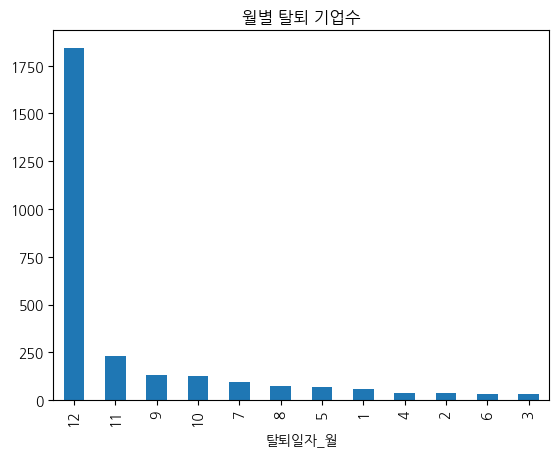

In [ ]:
# 코드를 입력해 주세요
df['탈퇴일자_연도'] =  pd.to_datetime(df['탈퇴일자']).dt.year
df['탈퇴일자_월'] =  pd.to_datetime(df['탈퇴일자']).dt.month
df.loc[(df['가입상태'] == 2) & (df['탈퇴일자_연도'] == 2023), '탈퇴일자_월'].astype('int').value_counts().plot(kind='bar')
plt.title('월별 탈퇴 기업수')
plt.show()

2023년도에 탈퇴한 기업을 대상으로 시도별 탈퇴한 기업의 숫자를 bar 그래프로 출력하세요

In [ ]:
df['주소'].str.split(' ').str[0]

0         서울특별시
1           경기도
2         서울특별시
3         서울특별시
4         서울특별시
          ...  
531530    부산광역시
531531         
531532         
531533     경상북도
531534     충청북도
Name: 주소, Length: 531535, dtype: object

In [ ]:
df['시도'] = df['주소'].str.split(' ').str[0]
df['시도'].apply(lambda x: len(x.strip())) > 0

0          True
1          True
2          True
3          True
4          True
          ...  
531530     True
531531    False
531532    False
531533     True
531534     True
Name: 시도, Length: 531535, dtype: bool

In [ ]:
df[(df['가입상태'] == 2) & (df['탈퇴일자_연도'] == 2023) & (df['시도'].apply(lambda x: len(x.strip())) > 0)]['시도']
# df.loc[(df['가입상태'] == 2) & (df['탈퇴일자_연도'] == 2023) & (df['시도'].apply(lambda x: len(x.strip())) > 0),'시도']

126       서울특별시
1170      서울특별시
4390      서울특별시
4636      서울특별시
5048      서울특별시
          ...  
531461    대구광역시
531482    부산광역시
531483    광주광역시
531492     충청남도
531503     전라남도
Name: 시도, Length: 2480, dtype: object

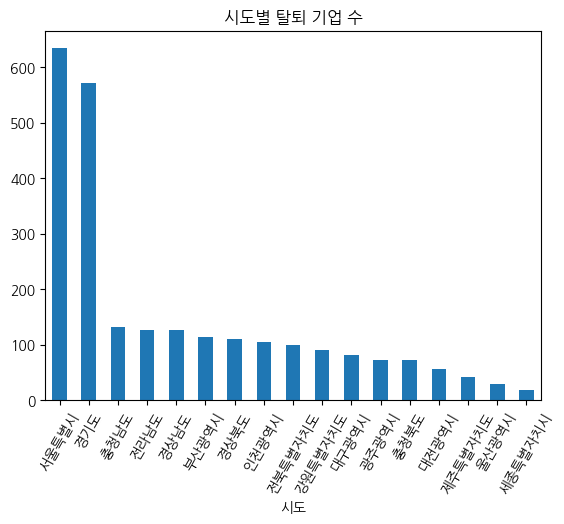

In [ ]:
# 코드를 입력해 주세요
df['시도'] = df['주소'].str.split(' ').str[0]
# df.loc[(df['가입상태'] == 2) & (df['탈퇴일자_연도'] == 2023) & (df['시도'].apply(lambda x: len(x.strip())) > 0), '시도'].value_counts().plot(kind='bar')
df.loc[(df['가입상태'] == 2) & (df['탈퇴일자_연도'] == 2023) & (df['시도'].apply(lambda x: len(x.strip())) > 0)]['시도'].value_counts().plot(kind='bar')
plt.title('시도별 탈퇴 기업 수')
plt.xticks(rotation=60)
plt.show()

탈퇴한 기업을 대상으로 상반기 / 하반기별 기업의 탈퇴 수를 비교합니다.
- 비교대상은 2017년 ~ 2024년을 기준으로 산정합니다.

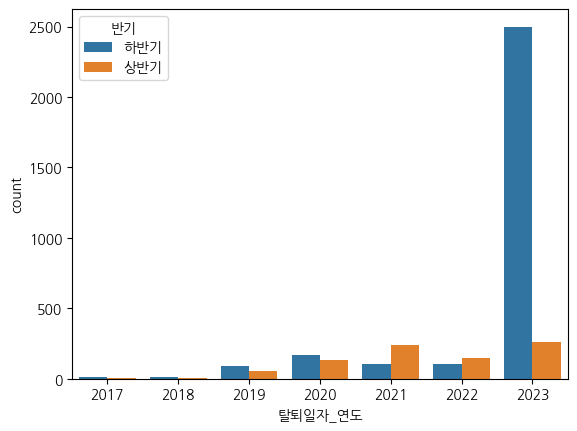

In [ ]:
# 코드를 입력해 주세요
cond1 = (df['가입상태'] == 2) & (df['탈퇴일자_연도'] >= 2017) & (df['탈퇴일자_연도'] <= 2023)
tmp = df.loc[cond1].copy()
tmp['반기'] = np.where(tmp['탈퇴일자_월'] <= 6, '상반기', '하반기')
tmp['탈퇴일자_연도'] = tmp['탈퇴일자_연도'].astype('int')
sns.countplot(x='탈퇴일자_연도', hue='반기', data=tmp)
# df = df.drop(['탈퇴일자_연도', '탈퇴일자_월','시도'], axis=1)
plt.show()

- `가입상태`가 2인 데이터는 삭제 합니다.
- `가입상태`, `탈퇴일자` 컬럼을 제거하세요.

In [ ]:
# 코드를 입력해 주세요
df = df.loc[df['가입상태'] == 1].drop(['가입상태', '탈퇴일자'], axis=1).reset_index(drop=True)
print(f'shape: {df.shape[0]} 행')
df.head()

shape: 519561 행


,사업장명,사업자등록번호,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,가입자수,금액,신규,상실
0,유삼송,116810,서울특별시 서초구 마방로6길,11,650,102,,NaN,209,73946060,4,3
1,주장성,214815,경기도 성남시 분당구 판교로,41,135,107,172902,그 외 기타 분류 안된 섬유제품 제조업,3,1163240,0,0
2,특수법인총포화약안전기술협회,118820,서울특별시 마포구 마포대로1길,11,440,105,742201,기타 기술 시험 검사 및 분석업,21,7623040,0,0
3,서울명지초등학교,111820,서울특별시 서대문구 명지2길,11,410,118,999999,BIZ_NO미존재사업장,31,6438280,0,0
4,삼양건설산업주,229810,서울특별시 서초구 동산로,11,650,102,451101,아파트 건설업,48,18749760,4,5


## 핵심 데이터 column 추출

- 수도권(서울, 경기도) 소재의 기업을 대상으로 합니다.
- `가입자수`를 기준으로 내림차순 정렬하여 bar 그래프를 출력합니다.
- 출력되는 사업장명은 상위 20개만 출력합니다.

In [ ]:
df.columns

Index(['사업장명', '사업자등록번호', '가입상태', '주소', '시도코드', '시군구코드', '읍면동코드', '업종코드',
       '업종코드명', '탈퇴일자', '가입자수', '금액', '신규', '상실', '탈퇴일자_연도', '탈퇴일자_월', '시도'],
      dtype='object')

In [ ]:
df[['시도코드','시도']]

,시도코드,시도
0,11,서울특별시
1,41,경기도
2,11,서울특별시
3,11,서울특별시
4,11,서울특별시
...,...,...
531530,26,부산광역시
531531,41,
531532,28,
531533,47,경상북도


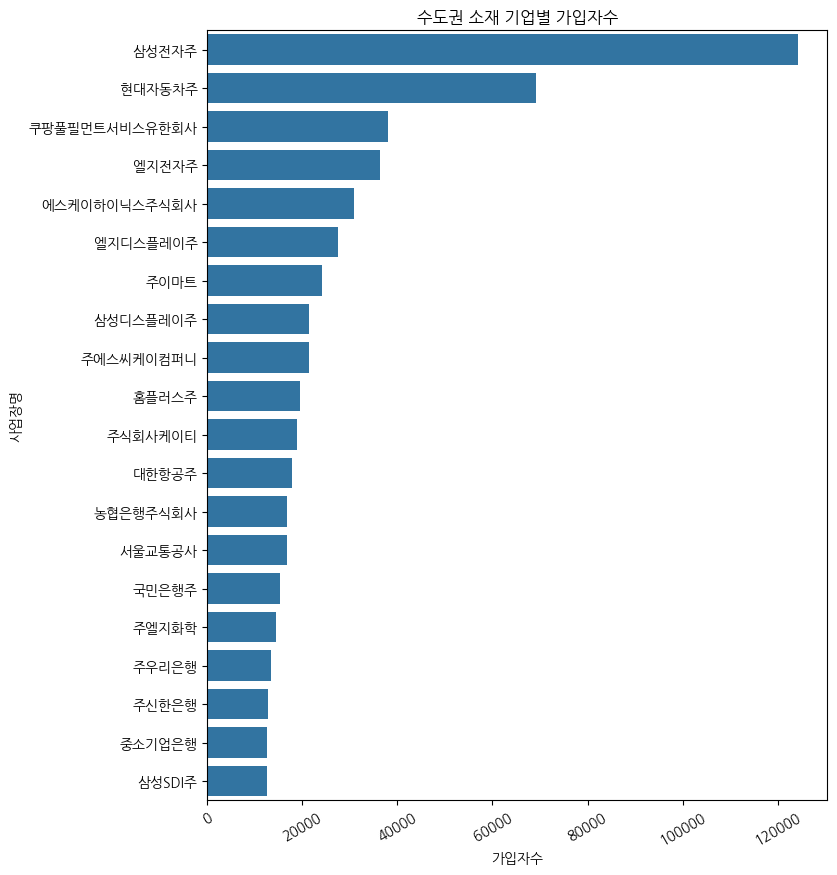

In [ ]:
# 코드를 입력해 주세요
plt.figure(figsize=(8, 10))
tmp = df.loc[df['시도코드'].isin([11, 41]), ['사업장명', '가입자수']].sort_values('가입자수', ascending=False).head(20).reset_index()
sns.barplot(y='사업장명', x='가입자수', data=tmp)
plt.xticks(rotation=30)
plt.title('수도권 소재 기업별 가입자수')
plt.show()

### 국민연금 납부액으로 기업별 평균 연봉 추정

국민연금 보험률은 9%입니다. 쉽게 이야기 하면 급여(신고소득월액)의 9%를 국민연금으로 내는 것입니다.

하지만 이를 절반으로 나누어 **4.5%는 회사가, 나머지 절반은 개인이 부담하는 구조**입니다. 회사는 급여 외에 추가로 금액을 부담합니다.

국민연금 보험료는 **소득 상한선과 하한선이 설정되어 있어 소득 전체가 아닌 일부 소득에만 부과**됩니다.

이를 역산하면 신고소득월액의 계산이 가능합니다. 하지만 **상한선과 하한선이 설정되어 있어 실제보다 과소계산**될 수 있습니다

[수식]

- 인당금액 = 금액 / 가입자수
- 월급여추정 = 인당금액 / 9% * 100%
- 연간급여추정 = 임직원 평균 월급 * 12개월

- 금액을 가입자수로 나눈 금액을 산출하여 `인당금액`을 먼저 산출합니다.
- `월급여추정`은 `인당금액` / 9% * 100% 한 값입니다.
- `월급여추정`을 x12한 값을 `연간급여추정`에 대입합니다.
- `가입자수` 기준 1000명을 초과하는 기업(중견기업)을 필터링 합니다.
- 출력시 `사업장명`, `가입자수`, `월급여추정`, `연간급여추정` 컬럼만 출력합니다.
- `연간급여추정`와 `가입자수`를 기준으로 내림차순하여 상위 10개 기업을 출력합니다.

In [ ]:
df.head()

In [ ]:
# 코드를 입력해 주세요
df['인당금액'] = df['금액'] / df['가입자수']
df['월급여추정'] =  df['인당금액'] / 9 * 100
df['연간급여추정'] = df['월급여추정'] * 12

cond = (df['가입자수'] > 1000)
df.sort_values(['연간급여추정', '가입자수'], ascending=False).loc[cond, ['사업장명', '가입자수', '월급여추정', '연간급여추정']].head(10)

,사업장명,가입자수,월급여추정,연간급여추정
6225,기아주영업본부,2292,5899753.1,70797036.6
215137,사부산항만산업협회화물고정업,1080,5894263.0,70731155.6
3472,삼성에스디에스주,11536,5851150.2,70213802.8
189761,삼성디스플레이주,21468,5850185.1,70202221.6
3151,주제일기획,1417,5846510.0,70158120.0
96175,현대제철주포항1공장,1532,5841256.0,70095072.2
255263,삼성물산주건설부문정규직,4588,5839419.5,70073033.4
135118,기아주AutoLand화성,12190,5834673.7,70016084.4
173339,주KB국민카드,1463,5831495.4,69977944.9
3484,주식회사현대케피코,1668,5830418.6,69965023.2


### 업종별 가입자수 순유입 산정

- `순유입`은 `신규` - `상실` 로 정의합니다.
- `업종코드명`별 순유입의 합산을 구한 후 상위 20개 `업종코드명`에 대하여 bar 그래프로 출력합니다.
- `순유입` 기준으로 내림차순 정렬합니다.

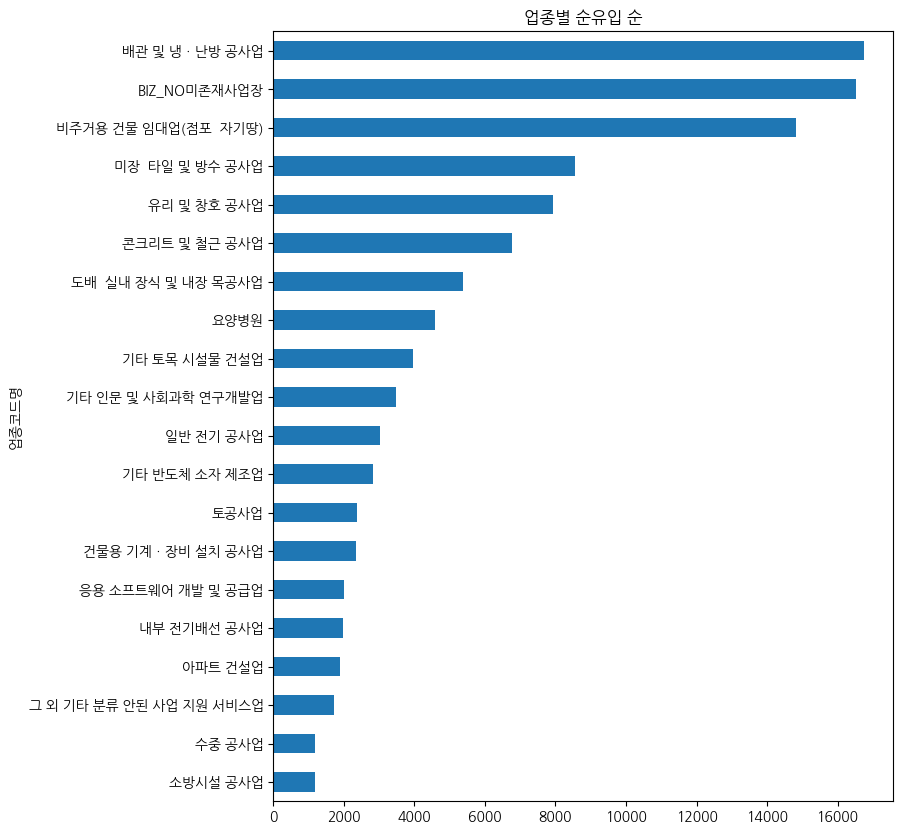

In [ ]:
# 코드를 입력해 주세요
plt.figure(figsize=(8, 10))
df['순유입'] = df['신규'] - df['상실']
df.groupby('업종코드명')['순유입'].sum().sort_values(ascending=False).head(20).sort_values().plot(kind='barh')
plt.title('업종별 순유입 순')
plt.show()

### 다음의 기능을 하는 함수를 완성하세요

- 사업자명을 검색한 후 결과를 return하는 함수를 완성합니다.
- 함수명은 `find_company` 입니다.
- 매개변수 contains:
          True인 경우: string의 `contains`를 사용하여 포함하는 모든 회사를 찾습니다.
          False인 경우: 정확히 일치하는 사업장명만 찾습니다.
          
- `def find_company(company_name, contains)`
- `['사업장명', '월급여추정', '연간급여추정', '업종코드']` 정보를 보여주는 DataFrame을 return 합니다.

In [ ]:
df.head()

In [ ]:
# 코드를 입력해 주세요
def find_company(company_name, contains):
    if contains:
        return df.loc[df['사업장명'].str.contains(company_name), ['사업장명', '월급여추정', '연간급여추정', '업종코드', '가입자수']]\
              .sort_values('가입자수', ascending=False)
    else:
        return df.loc[df['사업장명']==company_name, ['사업장명', '월급여추정', '연간급여추정', '업종코드', '가입자수']]\
              .sort_values('가입자수', ascending=False)

In [ ]:
# 검증코드
find_company('에스케이텔레콤', True)

,사업장명,월급여추정,연간급여추정,업종코드,가입자수
3010,에스케이텔레콤주,5664486.6,67973838.8,642001,5582
363077,에스케이텔레콤씨에스티원주,3612795.8,43353549.5,924101,74
420160,에스케이텔레콤주상용4단계운항통신시설구매설치사업,3578209.2,42938509.8,642001,17
456877,에스케이텔레콤주상용경북사업장형태선LTER,5765777.8,69189333.3,642001,5
129479,주식회사에스케이텔레콤봉화대리점,3803333.3,45640000.0,523323,3
237748,주에스케이텔레콤철원동송대리점,3127629.6,37531555.6,515060,3


In [ ]:
# 검증코드
find_company('에스케이텔레콤', False)

,사업장명,월급여추정,연간급여추정,업종코드,가입자수


- 사업장명을 입력하면 사업장명과 정확히 일치하는 회사를 찾습니다. (find_company 함수 사용)
- 함수명은 `compare_company` 입니다.
- 매개변수명은 `company_name` 으로 지정하세요
- `def compare_company(company_name)`

기능
- find_company로 부터 return 된 DataFrame의 업종코드와 동일한 회사를 모두 찾습니다.
- 동일한 회사의 `월급여추정`, `연간급여추정`에 대한 ['mean', 'count', 'min', 'max']를 산출합니다.

return 되는 DataFrame은 다음과 같이 구성합니다.
- index: `월급여추정` -> `업종_월급여추정`, `연간급여추정` -> `업종_연간급여추정`으로 변경합니다.
- 컬럼은 평균, 개수, 최소, 최대로 컬럼명을 변경 후 맨 끝열에는 찾은 회사명 컬럼을 추가하고, `월급여추정`, `연간급여추정` 데이터를 기입합니다.


In [ ]:
df.head()

In [ ]:
def company_info(company_name):
    company = find_company(company_name, True)
    return df.loc[company.iloc[0].name]

In [ ]:
info = company_info('에스케이텔레콤')
info

사업장명           에스케이텔레콤주
사업자등록번호          104813
가입상태                  1
주소         서울특별시 중구 을지로
시도코드                 11
시군구코드               140
읍면동코드               105
업종코드             642001
업종코드명       무선 및 위성 통신업
탈퇴일자                NaN
가입자수               5582
금액           2845724760
신규                   62
상실                   28
탈퇴일자_연도             NaN
탈퇴일자_월              NaN
시도                서울특별시
인당금액           509803.8
월급여추정         5664486.6
연간급여추정       67973838.8
순유입                  34
Name: 3010, dtype: object

In [ ]:
company = find_company('삼성전자', True)
code = company['업종코드'].iloc[0]

In [ ]:
df.loc[df['업종코드'] == code]

,사업장명,사업자등록번호,가입상태,주소,시도코드,시군구코드,읍면동코드,업종코드,업종코드명,탈퇴일자,가입자수,금액,신규,상실,탈퇴일자_연도,탈퇴일자_월,시도,인당금액,월급여추정,연간급여추정,순유입
831,교세라커넥터프로덕츠코리아주,119811,1,경기도 안산시 단원구 범지기로,41,273,105,323001,비디오 및 기타 영상 기기 제조업,NaN,107,45829940,0,3,NaN,NaN,경기도,428317.2,4759080.0,57108959.5,-3
1095,주지오엠씨,220812,1,경기도 성남시 수정구 창업로,41,131,115,323001,비디오 및 기타 영상 기기 제조업,NaN,5,1537720,0,0,NaN,NaN,경기도,307544.0,3417155.6,41005866.7,0
1503,한애전자주,208811,1,서울특별시 용산구 효창원로66길,11,170,119,323001,비디오 및 기타 영상 기기 제조업,NaN,3,1096900,0,0,NaN,NaN,서울특별시,365633.3,4062592.6,48751111.1,0
1918,티제이미디어주식회사,130814,1,서울특별시 마포구 월드컵북로,11,440,127,323001,비디오 및 기타 영상 기기 제조업,NaN,223,81493540,4,2,NaN,NaN,서울특별시,365441.9,4060465.4,48725584.5,2
2044,주대성하이테크전자,109812,1,,11,500,104,323001,비디오 및 기타 영상 기기 제조업,NaN,3,655280,0,0,NaN,NaN,,218426.7,2426963.0,29123555.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250708,주식회사두광,379880,1,경기도 포천시 내촌면 포천로427번길,41,650,320,323001,비디오 및 기타 영상 기기 제조업,NaN,4,1090420,0,0,NaN,NaN,경기도,272605.0,3028944.4,36347333.3,0
253306,주식회사엠피디테크,814870,1,경기도 부천시 원미구 조마루로397번길,41,192,101,323001,비디오 및 기타 영상 기기 제조업,NaN,16,5120320,0,0,NaN,NaN,경기도,320020.0,3555777.8,42669333.3,0
259997,주자이시스,629810,1,경기도 광명시 하안로,41,210,104,323001,비디오 및 기타 영상 기기 제조업,NaN,4,716760,0,0,NaN,NaN,경기도,179190.0,1991000.0,23892000.0,0
260326,블루웨이브텔,513852,1,경상북도 구미시 금오대로20길,47,190,118,323001,비디오 및 기타 영상 기기 제조업,NaN,7,1120120,0,0,NaN,NaN,경상북도,160017.1,1777968.3,21335619.0,0


In [ ]:
df1 =df.loc[df['업종코드'] == code, ['월급여추정', '연간급여추정']].agg(['mean', 'count', 'min', 'max'])


In [ ]:
df1.columns = ['업종_월급여추정', '업종_연간급여추정']

In [ ]:
df1 = df1.T

In [ ]:
df1.loc['업종_월급여추정', '삼성전자'] = company['월급여추정'].values[0]

In [ ]:
df1.loc['업종_연간급여추정', '삼성전자'] = company['연간급여추정'].values[0]

In [ ]:
df1

,mean,count,min,max,삼성전자
업종_월급여추정,3332120.9,268.0,509245.3,5850185.1,5742066.3
업종_연간급여추정,39985450.2,268.0,6110943.4,70202221.6,68904795.5


In [ ]:
code

'323001'

In [ ]:
company

In [ ]:
# 코드를 입력해 주세요
def compare_company(company_name):
    company = find_company(company_name, True)
    code = company['업종코드'].iloc[0]
    df1 =df.loc[df['업종코드'] == code, ['월급여추정', '연간급여추정']].agg(['mean', 'count', 'min', 'max'])
    df1.columns = ['업종_월급여추정', '업종_연간급여추정']
    df1 = df1.T
    df1.columns = ['평균', '개수', '최소', '최대']
    df1.loc['업종_월급여추정', company_name] = company['월급여추정'].values[0]
    df1.loc['업종_연간급여추정', company_name] = company['연간급여추정'].values[0]
    return df1

In [ ]:
# 검증코드
result = compare_company('삼성전자')
result

,평균,개수,최소,최대,삼성전자
업종_월급여추정,3332120.9,268.0,509245.3,5850185.1,5742066.3
업종_연간급여추정,39985450.2,268.0,6110943.4,70202221.6,68904795.5


In [ ]:
company.columns

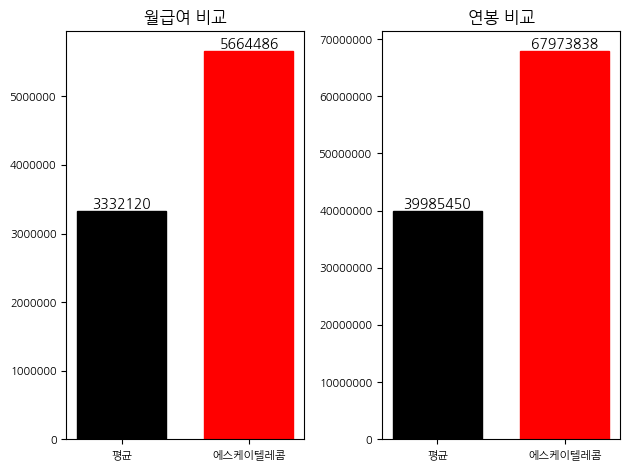

In [ ]:
fig, ax = plt.subplots(1, 2)

p1 = ax[0].bar(x=['평균', '에스케이텔레콤'], height=(result.iloc[0, 0], info['월급여추정']), width=0.7)
ax[0].bar_label(p1, fmt='%d')
p1[0].set_color('black')
p1[1].set_color('red')
ax[0].ticklabel_format(style='plain', axis='y')
ax[0].set_title('월급여 비교')

p2 = ax[1].bar(x=['평균', '에스케이텔레콤'], height=(result.iloc[1, 0], info['연간급여추정']), width=0.7)
p2[0].set_color('black')
p2[1].set_color('red')
ax[1].bar_label(p2, fmt='%d')
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_title('연봉 비교')

ax[0].tick_params(axis='both', which='major', labelsize=8, rotation=0)
ax[0].tick_params(axis='both', which='minor', labelsize=6)
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].tick_params(axis='both', which='minor', labelsize=6)

plt.tight_layout()

In [ ]:
# 검증코드
compare_company('현대자동차')

,평균,개수,최소,최대,현대자동차
업종_월급여추정,3627026.7,174.0,1585490.0,5899753.1,5514479.1
업종_연간급여추정,43524320.4,174.0,19025879.8,70797036.6,66173748.7


In [ ]:
# 검증코드
compare_company('버킷플레이스')

,평균,개수,최소,최대,버킷플레이스
업종_월급여추정,2883585.8,52687.0,370000.0,5900000.0,4705454.9
업종_연간급여추정,34603029.4,52687.0,4440000.0,70800000.0,56465459.0


In [ ]:
# 검증코드
compare_company('무신사')